**EDA And Predictive Modeling**

This single-file notebook performs exploratory data analysis, data cleaning,
feature engineering, and trains three machine learning models (Decision Trees, Random Forest, XGBoost) to predict the column (Healthy / Unhealthy).

Importing the libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
accuracy_score,
precision_score,
recall_score,
f1_score,
confusion_matrix,
roc_curve,
auc,
classification_report,
)

Loading the dataset from CSV file.

In [2]:
df = pd.read_csv("/content/VowelA_High_latest.csv")
print("Loaded dataset with shape:", df.shape)

Loaded dataset with shape: (2035, 32)


In [3]:
# Showing a quick sample
df.head()


,Unnamed: 0,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,ID,G,A
0,0,1-a_h.wav,0.127341,0.355538,1587.507015,2002.198851,2737.971816,0.066798,-233.566208,48.504421,...,-28.190628,1.143172,4.134034,52.794827,39.092403,49.037060,Healthy,1,w,20
1,1,10-a_h.wav,0.215317,0.250342,1272.900724,1850.302841,1692.919922,0.043325,-179.419601,119.705742,...,7.790230,-7.037875,-9.193601,11.183559,-2.173607,-9.420938,Healthy,10,w,22
2,2,100-a_h.wav,0.212512,0.251419,919.203795,1014.718104,1275.967478,0.047079,-209.186188,167.135651,...,-20.040691,-4.153456,-2.725145,-10.669723,-2.336876,7.741264,Healthy,100,m,66
3,3,1000-a_h.wav,0.198861,0.157396,1119.517351,1529.490600,1501.657586,0.045487,-210.244278,139.819519,...,-0.163550,7.797343,-26.314997,-6.622046,0.535120,0.749695,Healthy,1000,m,31
4,4,1002-a_h.wav,0.370113,0.143538,1060.678054,1346.299507,1524.942294,0.050109,-175.039948,181.905212,...,-20.939833,13.306650,-26.597456,-8.324528,10.786009,-6.677513,Healthy,1002,m,25


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          2035 non-null   int64  
 1   filename            2035 non-null   object 
 2   chroma_stft         2035 non-null   float64
 3   rmse                2035 non-null   float64
 4   spectral_centroid   2035 non-null   float64
 5   spectral_bandwidth  2035 non-null   float64
 6   rolloff             2035 non-null   float64
 7   zero_crossing_rate  2035 non-null   float64
 8   mfcc1               2035 non-null   float64
 9   mfcc2               2035 non-null   float64
 10  mfcc3               2035 non-null   float64
 11  mfcc4               2035 non-null   float64
 12  mfcc5               2035 non-null   float64
 13  mfcc6               2035 non-null   float64
 14  mfcc7               2035 non-null   float64
 15  mfcc8               2035 non-null   float64
 16  mfcc9 

In [5]:
df.columns.values

array(['Unnamed: 0', 'filename', 'chroma_stft', 'rmse',
       'spectral_centroid', 'spectral_bandwidth', 'rolloff',
       'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5',
       'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20', 'label', 'ID', 'G', 'A'], dtype=object)

### Cleaning the columns

This dataset contains audio-derived features that describe the acoustic properties of each recording.
These features will be used in this project to classify voice samples (e.g., predicting health condition, gender, or other voice-related traits).

| **Feature**            | **Meaning / Description**                                                                                                                                                                                                                      |
| ---------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **filename**           | The name of the audio file from which the features were extracted (e.g., `1-a_h.wav`).                                                                                                                                                         |
| **chroma_stft**        | *Chroma Short-Time Fourier Transform* — captures the energy distribution across the 12 pitch classes (C, C#, D, etc.), representing harmonic or tonal characteristics of sound.                                                                |
| **rmse**               | *Root Mean Square Energy* — measures the loudness or energy of the audio signal. Higher values = louder segments.                                                                                                                              |
| **spectral_centroid**  | Indicates where the "center of mass" of the spectrum is located. Higher values correspond to brighter (higher-pitched) sounds.                                                                                                                 |
| **spectral_bandwidth** | Measures the spread of the spectrum around its centroid — how wide the range of frequencies is. Larger values indicate more complex or noisy signals.                                                                                          |
| **rolloff**            | *Spectral roll-off frequency* — the frequency below which a certain percentage (usually 85–90%) of the signal energy is contained. Used to distinguish between harmonic and noisy sounds.                                                      |
| **zero_crossing_rate** | The rate at which the signal changes sign (from positive to negative or vice versa). Indicates noisiness or percussiveness — higher for unvoiced sounds.                                                                                       |
| **mfcc1 – mfcc20**     | *Mel-Frequency Cepstral Coefficients (MFCCs)* — numerical descriptors that capture the timbre (tone quality) of sound. Commonly used in speech and audio classification. Each coefficient represents a specific frequency band characteristic. |
| **label**              | The target variable — in this case, indicates *Health Status* (e.g., “Healthy” or “Unhealthy”).                                                                                                                                                |
| **ID**                 | A unique identifier for each audio sample or speaker.                                                                                                                                                                                          |
| **G**                  | Likely represents *Gender* (e.g., `m` = male, `w` = woman/female).                                                                                                                                                                             |
| **A**                  | Represents the *Age* of the individual whose voice was recorded.                                                                                                                                                                               |


Based on the above definitions or explainations of the features of this dataset, the columns will be renamed to more descriptive and intuitive names

Below is a mapping that aligns with the meaning of each feature while keeping names short, clear, and analysis-friendly.

| **Original Column**  | **New Column Name**   | **Description / Meaning**                                                                 |
| -------------------- | --------------------- | ----------------------------------------------------------------------------------------- |
| `chroma_stft`        | `Energy_Distribution` | Represents tonal or harmonic energy distribution across pitch classes.                    |
| `rmse`               | `Signal_Energy`       | Measures the overall loudness or power of the audio signal.                               |
| `spectral_centroid`  | `Spectral_Brightness` | Indicates the “brightness” of sound — the average frequency weighted by amplitude.        |
| `spectral_bandwidth` | `Spectral_Spread`     | Captures how wide or noisy the spectrum is around its centroid.                           |
| `rolloff`            | `Spectral_Rolloff`    | The frequency below which most of the signal’s energy (typically 85–90%) is contained.    |
| `zero_crossing_rate` | `Zero_Crossing_Rate`  | Rate of sign changes in the signal — reflects noisiness or unvoiced characteristics.      |
| `mfcc1` – `mfcc20`   | `MFCC_1` – `MFCC_20`  | Mel-Frequency Cepstral Coefficients — describe the timbre and tonal quality of the sound. |
| `label`              | `Health_Status`       | Indicates the health status of the speaker (e.g., *Healthy* or *Unhealthy*).              |
| `G`                  | `Gender`              | Gender of the speaker.                                                                    |
| `A`                  | `Age`                 | Age of the speaker.                                                                       |


In [6]:
# Remove the unnamed first column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop redundant columns of 'filename' and 'ID'
df = df.drop(columns=['filename', 'ID'], errors='ignore')



In [7]:
# Rename columns based on feature meanings
rename_dict = {
    'chroma_stft': 'Energy_Distribution',
    'rmse': 'Signal_Energy',
    'spectral_centroid': 'Spectral_Brightness',
    'spectral_bandwidth': 'Spectral_Spread',
    'rolloff': 'Spectral_Rolloff',
    'zero_crossing_rate': 'Zero_Crossing_Rate',
    'label': 'Health_Status',
    'G': 'Gender',
    'A': 'Age'
}

# Rename MFCC columns (mfcc1 to mfcc20)
mfcc_mapping = {f'mfcc{i}': f'MFCC_{i}' for i in range(1, 21)}

# Combine dictionaries
rename_dict.update(mfcc_mapping)

# Apply renaming
df = df.rename(columns=rename_dict)

# Optional: check the new column names
print(df.columns)


Index(['Energy_Distribution', 'Signal_Energy', 'Spectral_Brightness',
       'Spectral_Spread', 'Spectral_Rolloff', 'Zero_Crossing_Rate', 'MFCC_1',
       'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
       'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'MFCC_14',
       'MFCC_15', 'MFCC_16', 'MFCC_17', 'MFCC_18', 'MFCC_19', 'MFCC_20',
       'Health_Status', 'Gender', 'Age'],
      dtype='object')


In [8]:
# Showing a quick sample
df.head()

,Energy_Distribution,Signal_Energy,Spectral_Brightness,Spectral_Spread,Spectral_Rolloff,Zero_Crossing_Rate,MFCC_1,MFCC_2,MFCC_3,MFCC_4,...,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,Health_Status,Gender,Age
0,0.127341,0.355538,1587.507015,2002.198851,2737.971816,0.066798,-233.566208,48.504421,-34.518085,-36.272301,...,-13.107756,-28.190628,1.143172,4.134034,52.794827,39.092403,49.037060,Healthy,w,20
1,0.215317,0.250342,1272.900724,1850.302841,1692.919922,0.043325,-179.419601,119.705742,0.882231,-25.167576,...,-23.927071,7.790230,-7.037875,-9.193601,11.183559,-2.173607,-9.420938,Healthy,w,22
2,0.212512,0.251419,919.203795,1014.718104,1275.967478,0.047079,-209.186188,167.135651,-37.398190,-12.435701,...,-0.607183,-20.040691,-4.153456,-2.725145,-10.669723,-2.336876,7.741264,Healthy,m,66
3,0.198861,0.157396,1119.517351,1529.490600,1501.657586,0.045487,-210.244278,139.819519,-7.774013,13.630911,...,12.742208,-0.163550,7.797343,-26.314997,-6.622046,0.535120,0.749695,Healthy,m,31
4,0.370113,0.143538,1060.678054,1346.299507,1524.942294,0.050109,-175.039948,181.905212,-33.181606,-0.091763,...,-2.583305,-20.939833,13.306650,-26.597456,-8.324528,10.786009,-6.677513,Healthy,m,25


# The common units or measurement scales of the features in this dataset.

| **Feature**                               | **Unit / Scale**           | **Explanation**                                                                                                                      |
| ----------------------------------------- | -------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| `Energy_Distribution` (chroma_stft)       | Unitless / normalized      | Represents relative energy in each pitch class (C, C#, D, …); values are normalized between 0 and 1.                                 |
| `Signal_Energy` (rmse)                    | Unitless / normalized      | Root Mean Square Energy of the signal; typically normalized between 0 and 1 (proportional to amplitude).                             |
| `Spectral_Brightness` (spectral_centroid) | Hz                         | Weighted mean of the frequency spectrum; higher = brighter sound.                                                                    |
| `Spectral_Spread` (spectral_bandwidth)    | Hz                         | Standard deviation of the spectrum around the centroid; indicates how “wide” or noisy the sound is.                                  |
| `Spectral_Rolloff` (rolloff)              | Hz                         | Frequency below which a specified portion (usually 85–90%) of the total spectral energy is contained.                                |
| `Zero_Crossing_Rate`                      | Rate (crossings per frame) | Number of times the signal changes sign per frame; unitless but proportional to signal frequency.                                    |
| `MFCC_1 – MFCC_20`                        | Unitless / arbitrary scale | Coefficients from the Mel-Frequency Cepstrum; describe the spectral envelope and timbre. Scale depends on signal processing library. |
| `Health_Status`                           | Categorical                | “Healthy” or “Unhealthy”; no numeric unit.                                                                                           |
| `Gender`                                  | Categorical                | “Male” or “Female”; no numeric unit.                                                                                                 |
| `Age`                                     | Years                      | Age of the speaker.                                                                                                                  |


In [9]:
# Inspecting the data types of the dataframe df
df.dtypes

,0
Energy_Distribution,float64
Signal_Energy,float64
Spectral_Brightness,float64
Spectral_Spread,float64
Spectral_Rolloff,float64
Zero_Crossing_Rate,float64
MFCC_1,float64
MFCC_2,float64
MFCC_3,float64
MFCC_4,float64


**Checking Missing Values & Duplicates**

In [10]:
# Missing values per column
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

# Duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Count missing values in each column
df.isnull().sum()

Missing values:
 Series([], dtype: int64)
Duplicate rows: 0


,0
Energy_Distribution,0
Signal_Energy,0
Spectral_Brightness,0
Spectral_Spread,0
Spectral_Rolloff,0
Zero_Crossing_Rate,0
MFCC_1,0
MFCC_2,0
MFCC_3,0
MFCC_4,0


### The dataset contains no missing values and no duplicate records.

## **Quick dataset overview and summary statistics**

In [11]:
df.describe().round(3)

,Energy_Distribution,Signal_Energy,Spectral_Brightness,Spectral_Spread,Spectral_Rolloff,Zero_Crossing_Rate,MFCC_1,MFCC_2,MFCC_3,MFCC_4,...,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,Age
count,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000,...,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000,2035.000
mean,0.227,0.192,1316.675,1684.034,2092.417,0.055,-204.067,126.722,-22.393,-21.094,...,-1.664,-8.734,-5.350,-9.339,-4.454,-10.471,-0.211,-3.224,-0.087,42.735
std,0.066,0.064,401.289,434.532,1243.022,0.020,46.306,30.334,26.034,16.992,...,11.954,12.347,10.617,10.776,9.846,10.680,11.276,11.862,13.606,18.136
min,0.120,0.015,566.319,830.011,698.963,0.012,-364.191,34.766,-98.050,-71.211,...,-37.990,-43.904,-41.178,-42.944,-33.339,-47.471,-39.700,-37.845,-26.634,9.000
25%,0.183,0.147,1056.074,1376.520,1311.851,0.043,-233.580,105.017,-40.444,-33.235,...,-10.043,-17.093,-12.539,-16.604,-11.197,-17.044,-7.253,-10.622,-8.398,24.000
50%,0.214,0.186,1233.787,1592.464,1627.910,0.053,-206.244,125.548,-22.963,-21.417,...,-2.097,-9.218,-5.644,-9.219,-4.848,-10.672,-0.787,-4.538,-2.492,42.000
75%,0.251,0.231,1468.927,1905.480,2419.183,0.064,-176.143,147.534,-4.734,-9.919,...,6.365,-0.459,1.464,-2.087,1.613,-4.567,5.772,2.185,4.520,59.000
max,0.614,0.464,4295.112,3403.279,8581.931,0.272,5.806,231.070,62.088,78.430,...,45.300,37.464,39.626,36.622,50.496,43.146,57.036,53.712,60.703,94.000


# Insights from the summary statistics
Energy Features: Most recordings have moderate energy (Signal_Energy ~0.192) and tonal distribution (Energy_Distribution ~0.227), with a few high-energy outliers.

Spectral Features: Average spectral centroid ~1316 Hz; signals are mostly low-to-mid frequency with moderate spread and some high-frequency outliers (Spectral_Rolloff up to 8581 Hz).

MFCCs: Timbre features vary moderately; a few extreme values indicate potential outliers or noisy recordings.

Age: Median age 42, majority of speakers between 24–59 years, range 9–94.

In [12]:
# checking the counts of the target variable (health stauts)
df.Health_Status.value_counts()

,count
Health_Status,
Unhealthy,1348
Healthy,687


In [13]:
(df.Health_Status.value_counts()/len(df)* 100).round(3)

,count
Health_Status,
Unhealthy,66.241
Healthy,33.759


In [14]:
# Export DataFrame to CSV
df.to_csv('Vowel_A_clean.csv', index=False)

Encoding the columns of Gender and Health_Status  ==== later we will do encoding

In [15]:
# Make a copy to avoid changing the original DataFrame
df_encoded = df.copy()

# Encode Gender: w -> 0, m -> 1
df_encoded['Gender'] = df_encoded['Gender'].map({'w': 0, 'm': 1})

# Encode Health_Status: Healthy -> 1, Unhealthy -> 0
df_encoded['Health_Status'] = df_encoded['Health_Status'].map({'Healthy': 1, 'Unhealthy': 0})

# Check the result
print(df_encoded[['Gender', 'Health_Status']].head())


   Gender  Health_Status
0       0              1
1       0              1
2       1              1
3       1              1
4       1              1


# **Performing cleaning **



*   Encoding the Gender Cloumn values to Female and Male
*   Creating a new columns for Age bins



In [16]:
# Make a copy to avoid changing the original DataFrame
df_new = df.copy()
# Encode Gender: w -> Female, m -> Male
df_new['Gender'] = df_new['Gender'].map({'w': "Female", 'm': "Male"})
# Define bins and labels
age_bins = [0, 20, 40, 60, np.inf]
age_labels = ['Below-20', '21-40', '41-60', 'Above-61']


# Create Age_Bin column
df_new['Age_Bin'] = pd.cut(df_new['Age'], bins=age_bins, labels=age_labels, right=True)

# Check results
print(df_new[['Age', 'Age_Bin']].head(5))
print(df_new[['Age', 'Age_Bin']].tail(5))

   Age   Age_Bin
0   20  Below-20
1   22     21-40
2   66  Above-61
3   31     21-40
4   25     21-40
      Age   Age_Bin
2030   67  Above-61
2031   14  Below-20
2032   55     41-60
2033   39     21-40
2034   38     21-40


In [17]:
df_new['Age_Bin'].value_counts()

,count
Age_Bin,
21-40,717
41-60,637
Above-61,423
Below-20,258


In [18]:
df_new.columns.values

array(['Energy_Distribution', 'Signal_Energy', 'Spectral_Brightness',
       'Spectral_Spread', 'Spectral_Rolloff', 'Zero_Crossing_Rate',
       'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6',
       'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12',
       'MFCC_13', 'MFCC_14', 'MFCC_15', 'MFCC_16', 'MFCC_17', 'MFCC_18',
       'MFCC_19', 'MFCC_20', 'Health_Status', 'Gender', 'Age', 'Age_Bin'],
      dtype=object)

## **Exploratory Analysis**

## Univariate Analysis

Univariate analysis for the target varailbe and categorlical features.
**Target and categorical distributions**

Goal:
To examine the distribution of categorical variables — Health Status, Gender, and Age Bins — to understand the composition of the inspected patients.

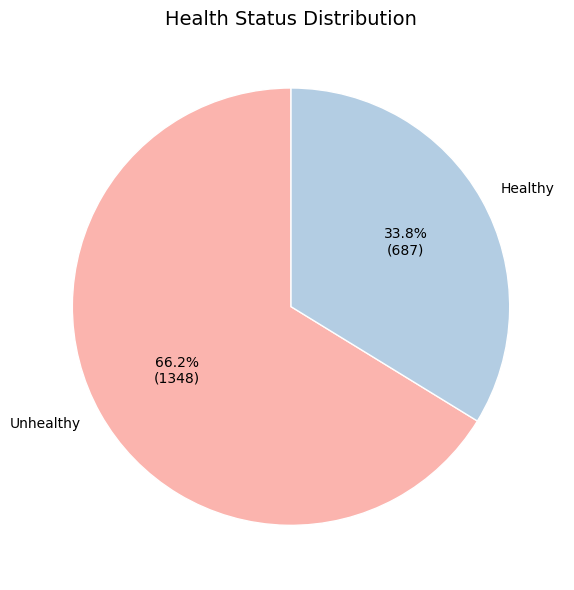

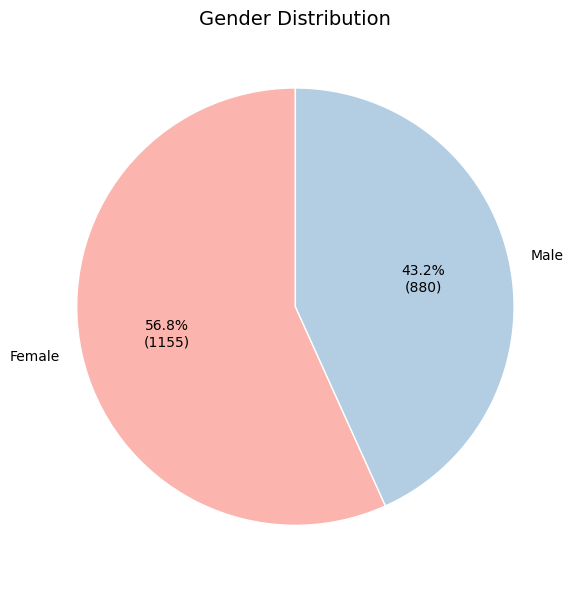

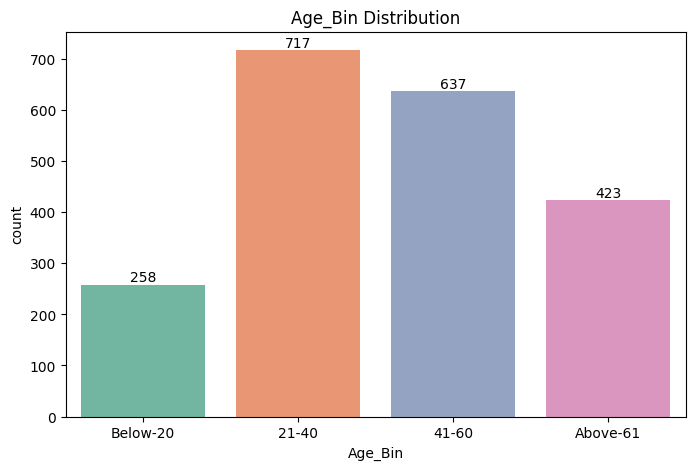

In [19]:
# Health Status Distribution (Pie Chart)
# -----------------------------
health_counts = df_new['Health_Status'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    health_counts,
    labels=health_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(health_counts) / 100)})',
    startangle=90,
     colors=plt.cm.Pastel1.colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Health Status Distribution', fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------
# Gender Distribution (Pie Chart)
# -----------------------------
gender_counts = df_new['Gender'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(gender_counts) / 100)})',
    startangle=90,
    colors=plt.cm.Pastel1.colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Gender Distribution', fontsize=14)
plt.tight_layout()
plt.show()

# Age Bin Distribution (bar chart)
plt.figure(figsize=(8,5))
ax = sns.countplot(x='Age_Bin', data=df_new, hue='Age_Bin', palette='Set2',
                   order=['Below-20','21-40','41-60','Above-61'], legend=False)
plt.title('Age_Bin Distribution')

# Add value labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.1, int(height),
            ha='center', va='bottom', fontsize=10)

plt.show()

### ***Insights***

1.  The number of Unhealthy individuals exceeds that of Healthy ones.
1.  Female individuals are more frequent than Male ones.
2.  Most of the individuals fall within the 21–40 years age group.

# Univariate Analysis for the Numerical Features

,count,mean,std,min,25%,50%,75%,max
Energy_Distribution,2035.0,0.226609,0.065532,0.120402,0.182932,0.213884,0.251294,0.614178
Signal_Energy,2035.0,0.192420,0.064474,0.015067,0.147187,0.186241,0.231145,0.463574
Spectral_Brightness,2035.0,1316.674901,401.289370,566.319248,1056.073776,1233.786591,1468.926577,4295.111712
Spectral_Spread,2035.0,1684.033835,434.532199,830.011306,1376.519591,1592.463814,1905.480356,3403.279259
Spectral_Rolloff,2035.0,2092.416751,1243.021777,698.962823,1311.850933,1627.910156,2419.182517,8581.931440
Zero_Crossing_Rate,2035.0,0.054684,0.020236,0.012267,0.043071,0.053438,0.063741,0.271903
MFCC_1,2035.0,-204.067168,46.305767,-364.190887,-233.579994,-206.244324,-176.142578,5.806334
MFCC_2,2035.0,126.722018,30.334038,34.765537,105.017399,125.547623,147.534126,231.070160
MFCC_3,2035.0,-22.393496,26.034214,-98.049812,-40.443611,-22.962688,-4.733893,62.088444
MFCC_4,2035.0,-21.094475,16.991732,-71.211227,-33.235329,-21.416739,-9.918872,78.430466


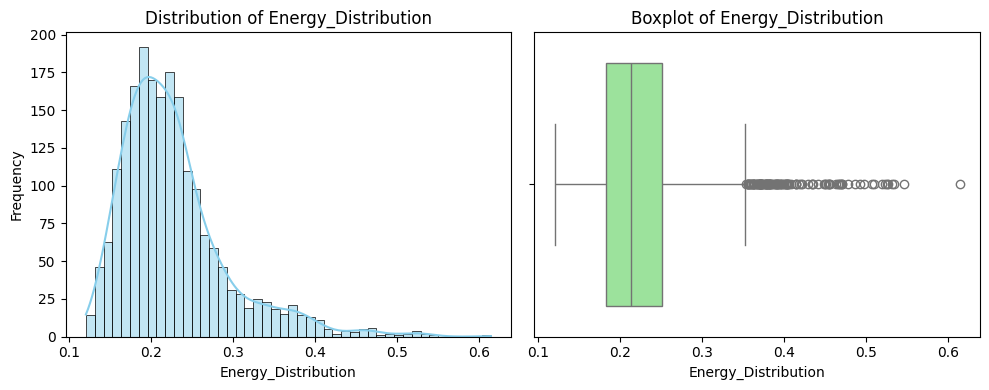

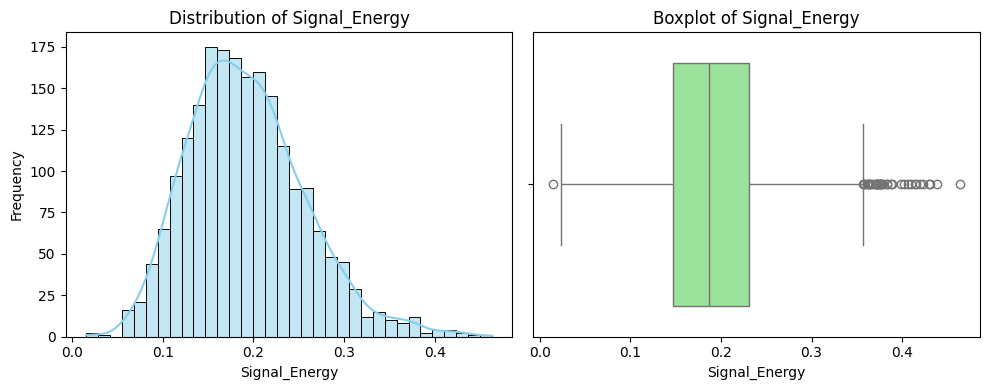

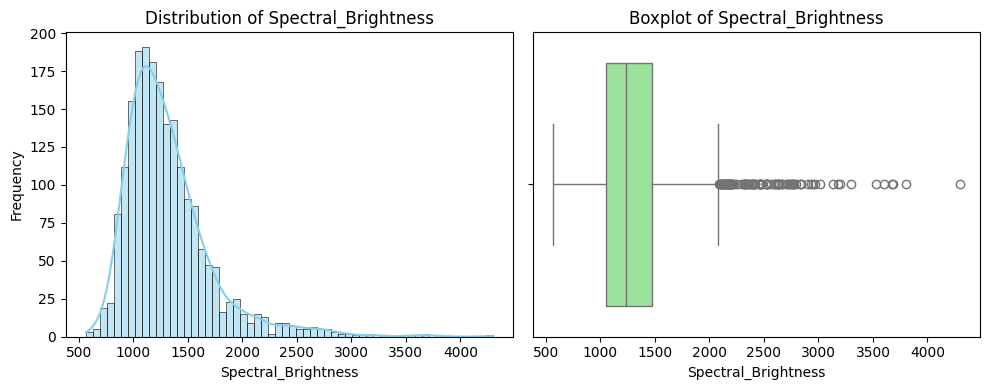

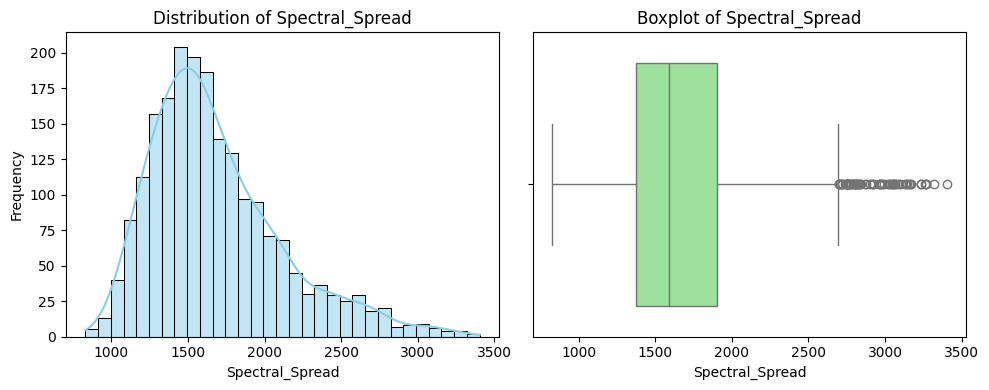

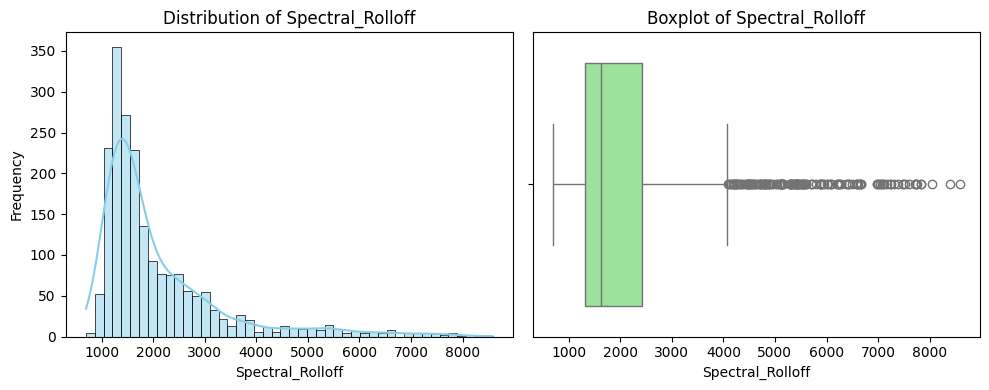

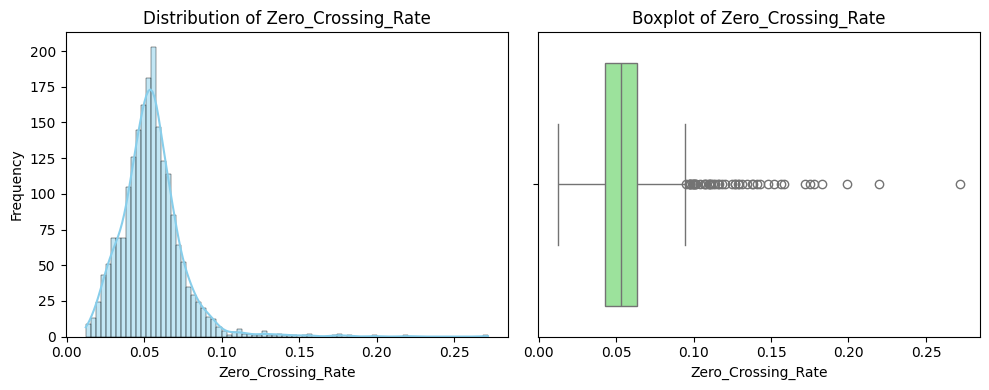

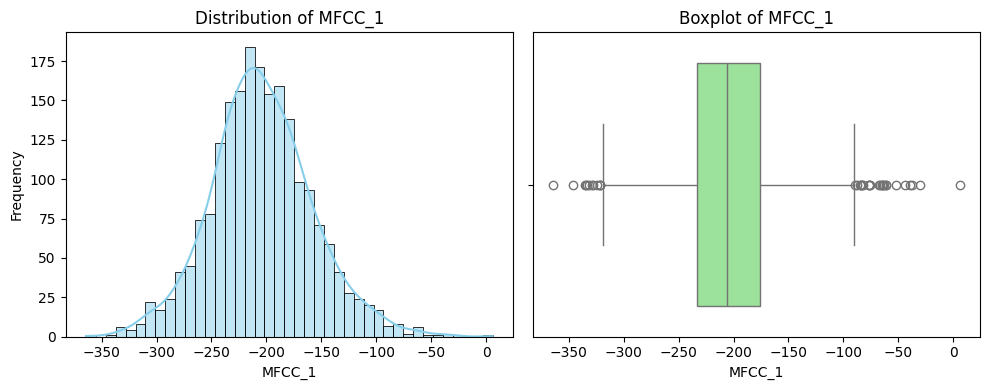

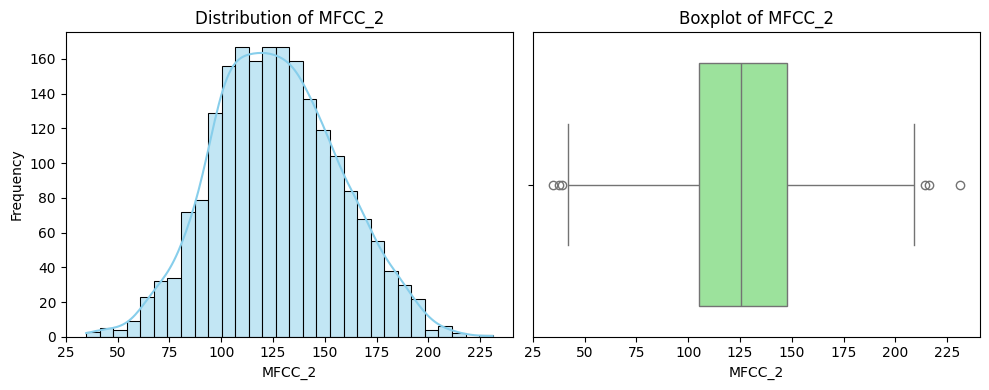

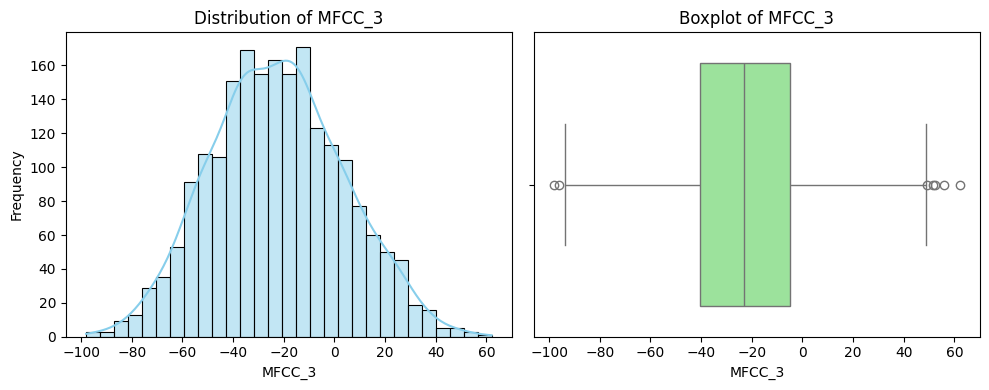

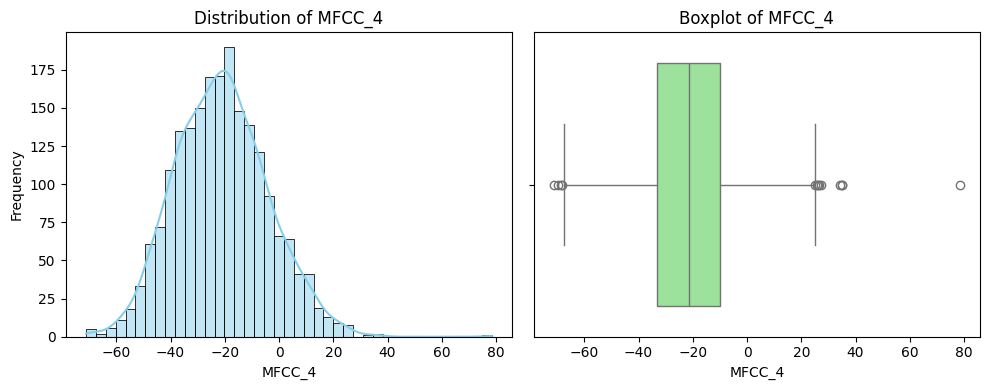

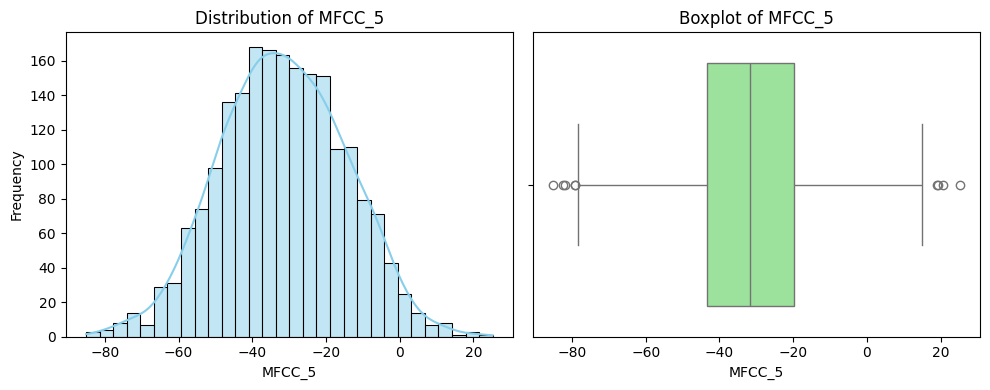

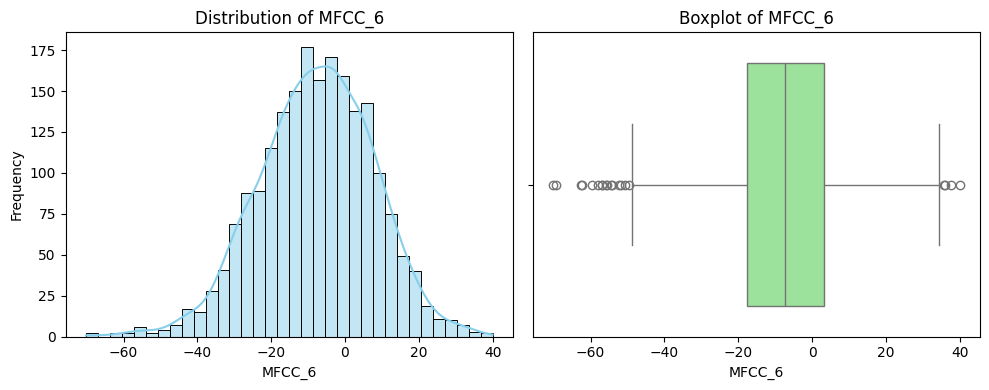

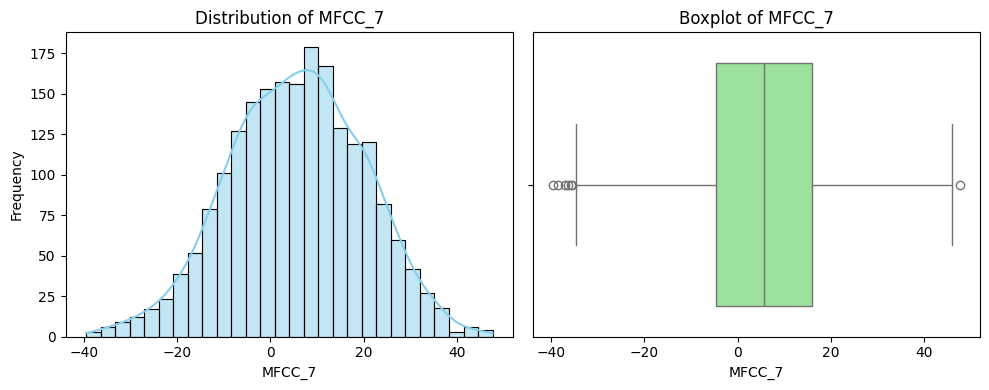

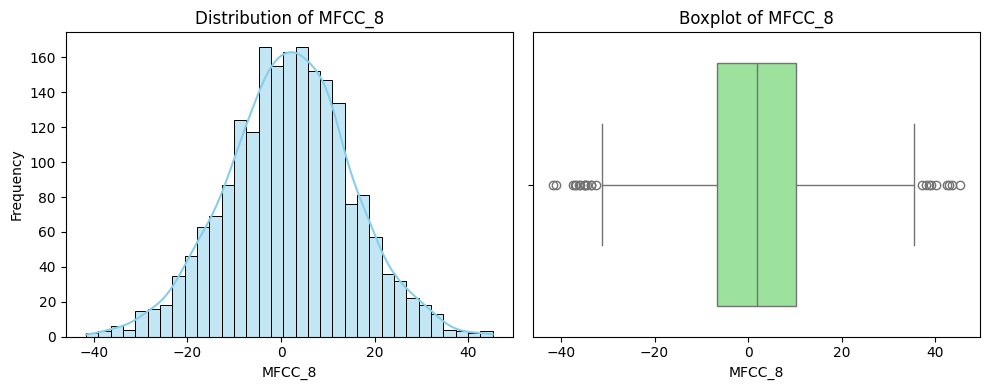

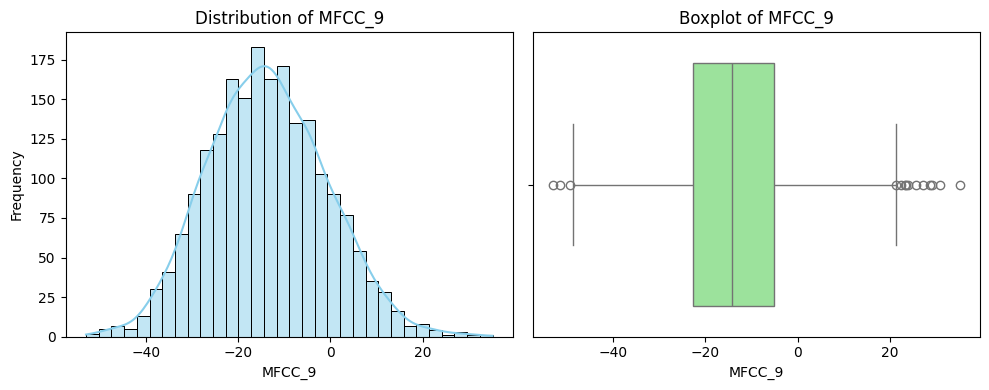

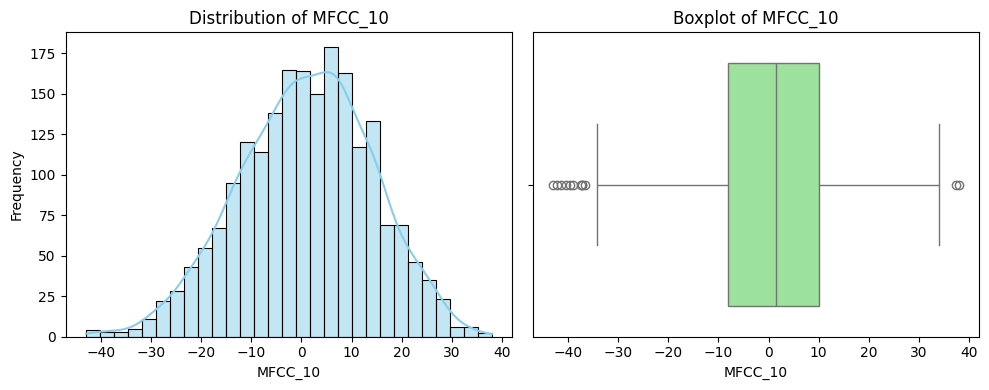

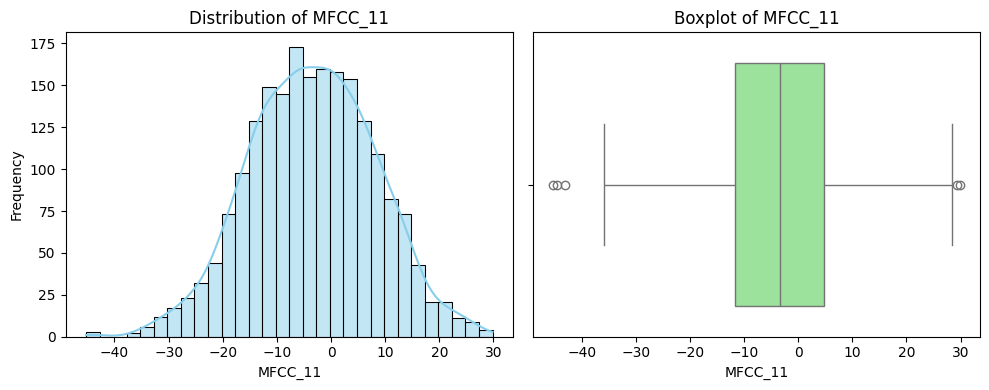

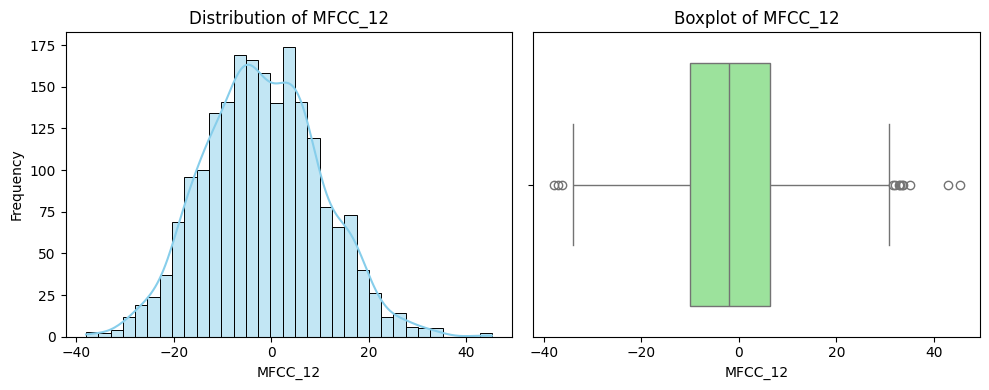

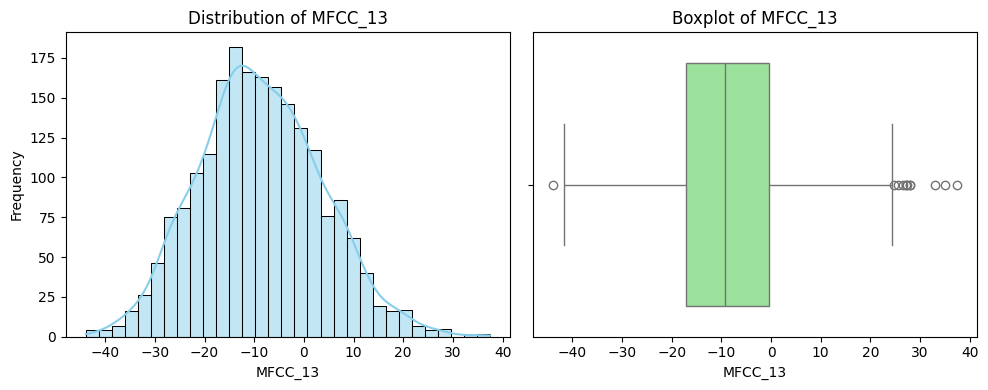

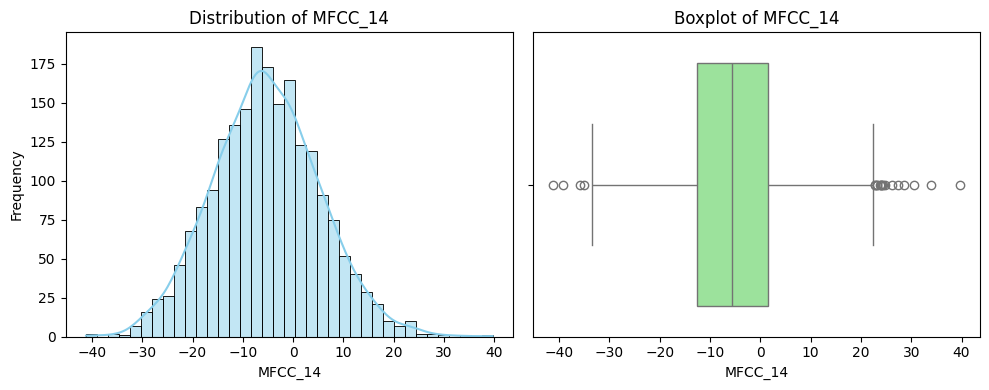

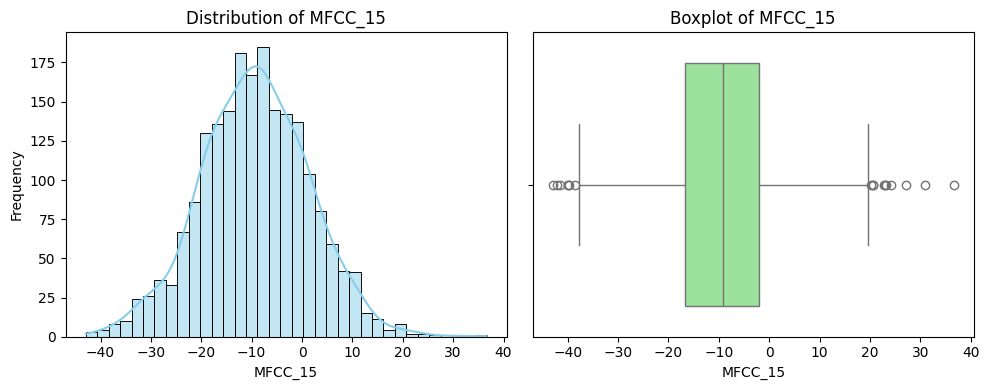

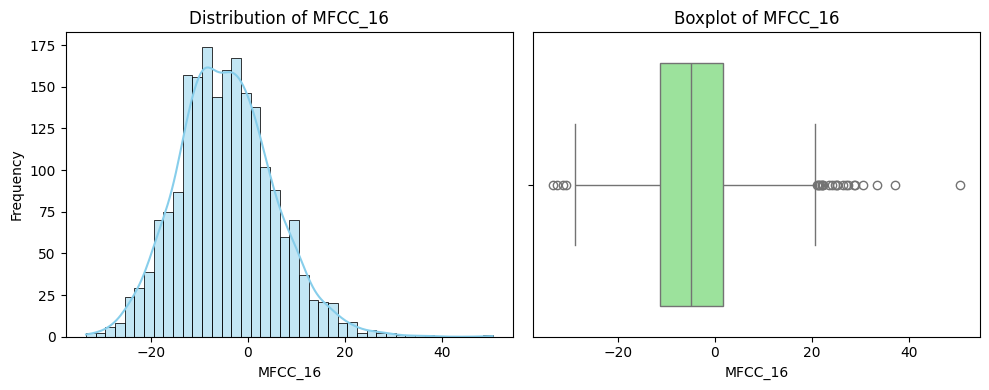

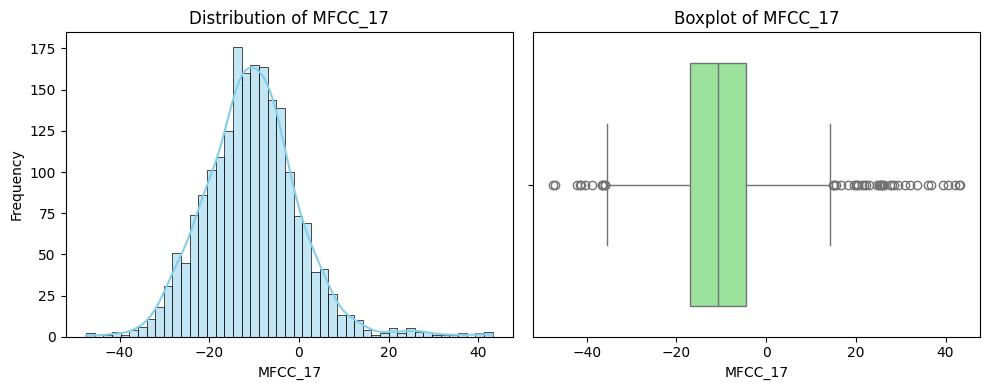

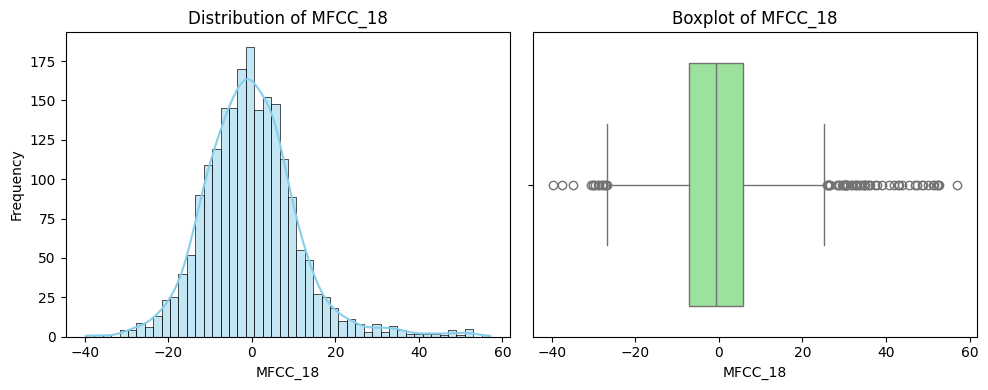

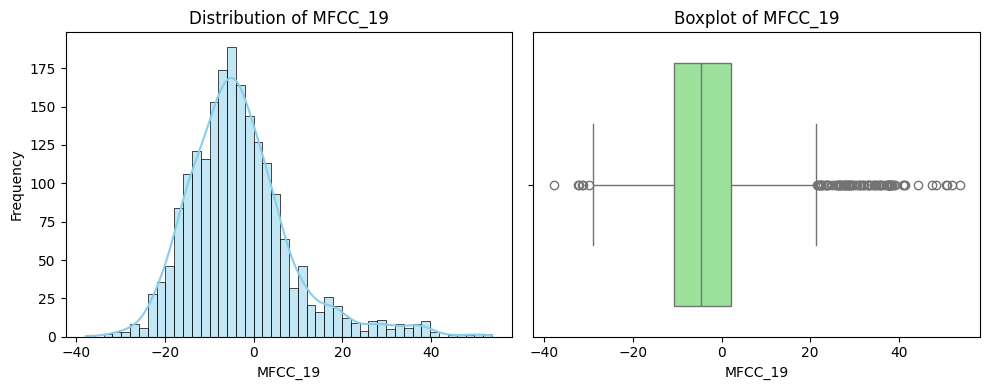

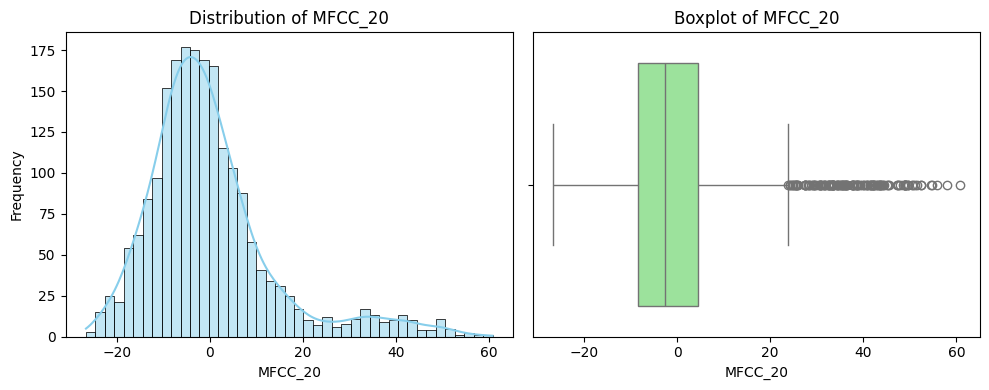

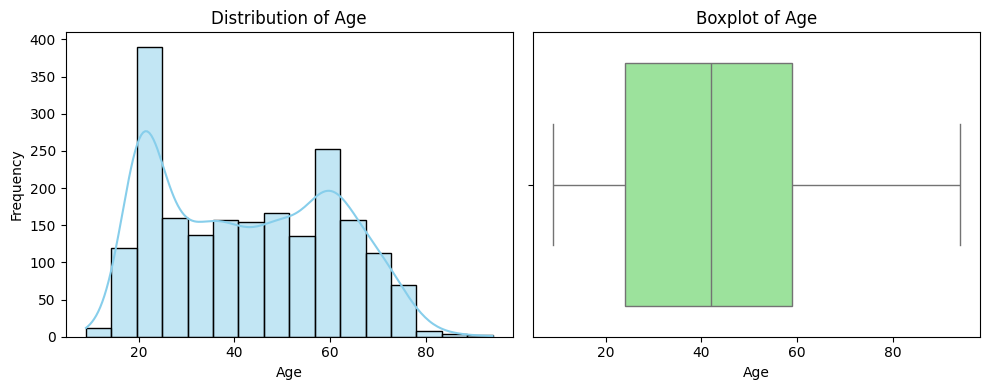

In [20]:
# Select numerical columns
num_cols = df_new.select_dtypes(include=['float64', 'int64']).columns

# Summary statistics
display(df_new[num_cols].describe().T)

# Univariate plots for each numerical column
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Histogram + KDE
    sns.histplot(df_new[col], kde=True, color='skyblue', ax=axes[0])
    axes[0].set_title(f'Distribution of {col}', fontsize=12)
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Boxplot (to detect outliers)
    sns.boxplot(x=df_new[col], color='lightgreen', ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}', fontsize=12)
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

## Insights

The numerical features were examined for their distributional patterns, skewness, and presence of outliers. The variables Energy_Distribution, Spectral_Brightness, Spectral_Rolloff, Zero_Crossing_Rate, MFCC_4, MFCC_19, and MFCC_20 exhibited noticeable positive skewness and contained several outliers, suggesting potential variability or extreme values in these measurements.

On the other hand, the feature Signal_Energy and the majority of the Mel-Frequency Cepstral Coefficients (MFCCs) — particularly MFCC_2, MFCC_3, MFCC_5, and MFCC_7 — showed approximately symmetric distributions with minimal skewness and few outliers. These variables appear to be relatively well-behaved and normally distributed.

Overall, the analysis indicates that while most numerical variables follow a near-normal distribution, a subset demonstrates skewness and the presence of outliers, which may require transformation or scaling during the modeling phase to improve model performance and stability.

# Bivariate analysis
The target variable "Health_Status" vs the Categorical feature Gender

=== Cross-tabulation: Gender vs Health_Status ===
Health_Status  Healthy  Unhealthy
Gender                           
Female             428        727
Male               259        621

=== Proportional Table (Row %) ===
Health_Status  Healthy  Unhealthy
Gender                           
Female           37.06      62.94
Male             29.43      70.57


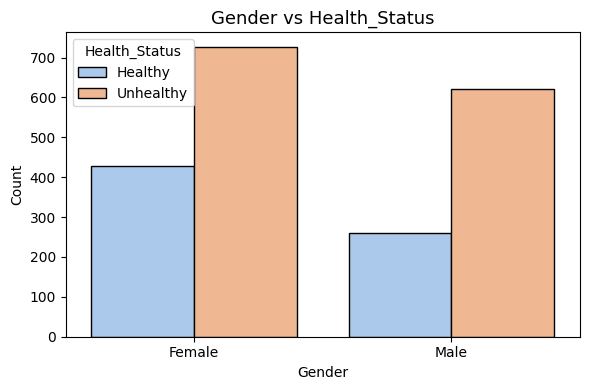

In [21]:
# ------------- Frequency Table (Cross-tab) -------------
cross_tab = pd.crosstab(df_new['Gender'], df_new['Health_Status'])
print("=== Cross-tabulation: Gender vs Health_Status ===")
print(cross_tab)
print("\n=== Proportional Table (Row %) ===")
print((cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100).round(2))

# ------------- Visualization -------------
plt.figure(figsize=(6,4))
sns.countplot(
    x='Gender', hue='Health_Status',
    data=df_new, palette='pastel', edgecolor='black'
)
plt.title('Gender vs Health_Status', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Health_Status')
plt.tight_layout()
plt.show()

## Insights
Although the dataset contains a higher proportion of female individuals (56.8%) compared to males (43.2%), the proportion of unhealthy males (70.6%) is notably higher than that of unhealthy females (63.9%). This suggests that despite females being more represented in the dataset overall, males exhibit a greater prevalence of unhealthy conditions.

# Bivariate analysis
The target variable "Health_Status" vs the numerical features

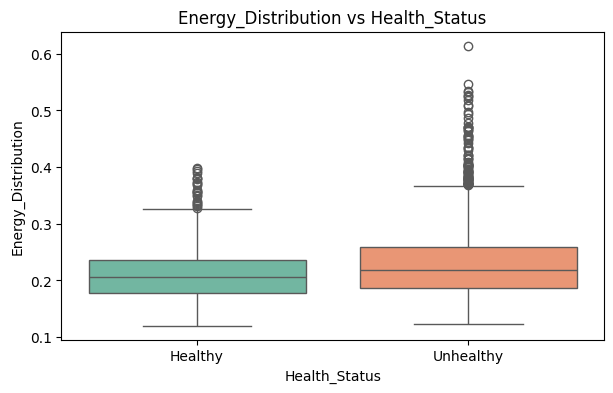

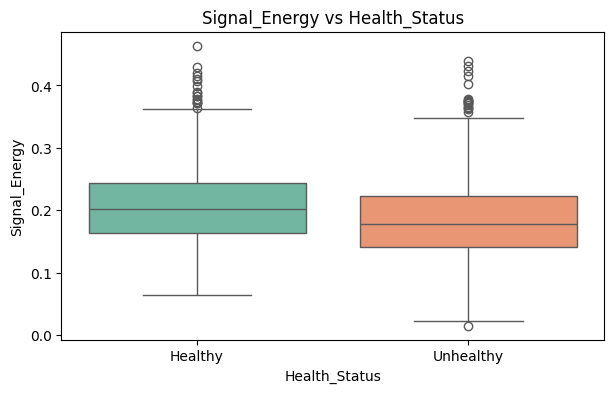

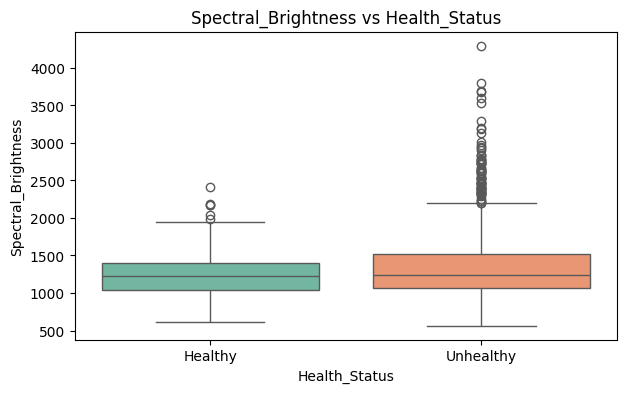

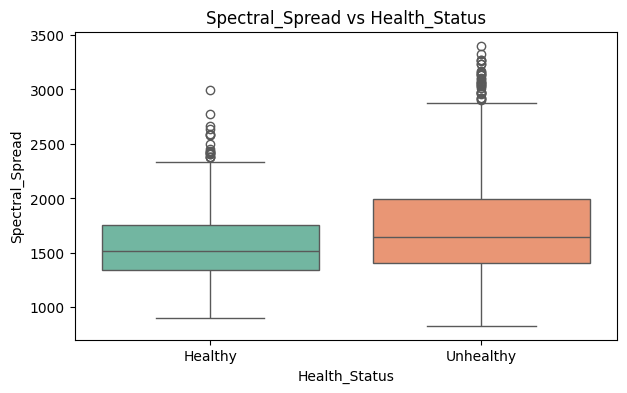

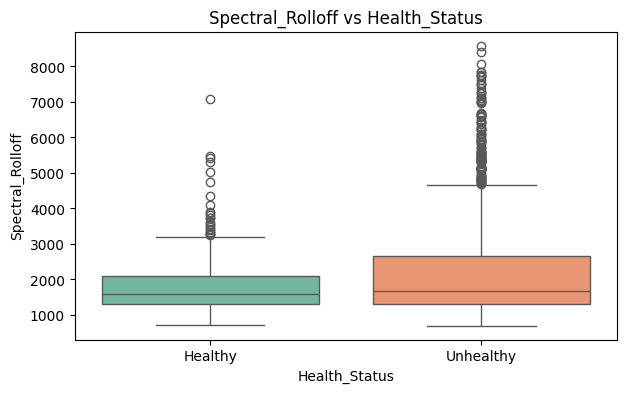

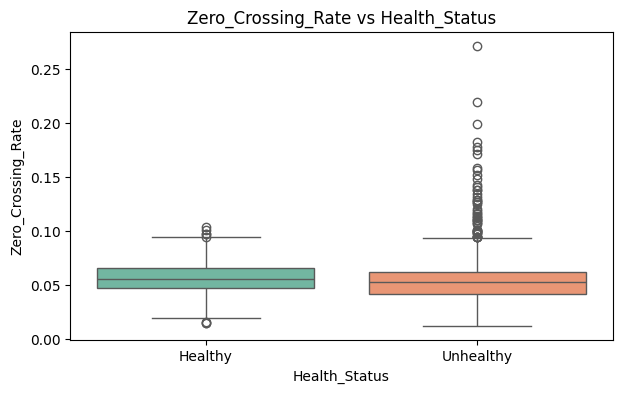

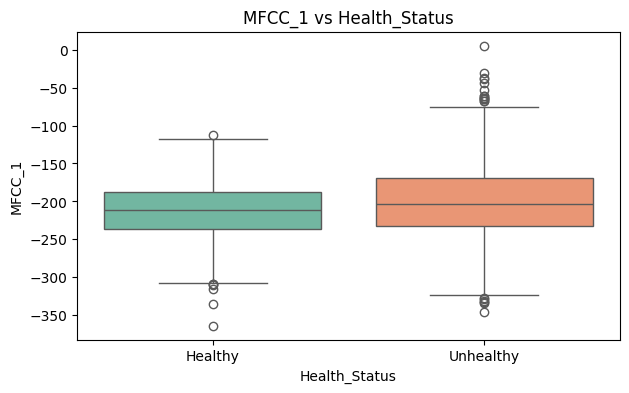

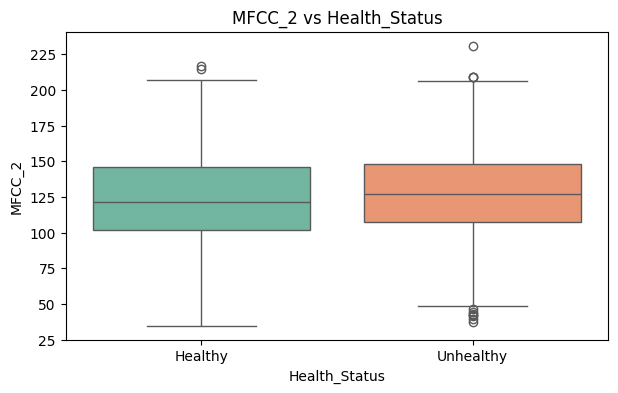

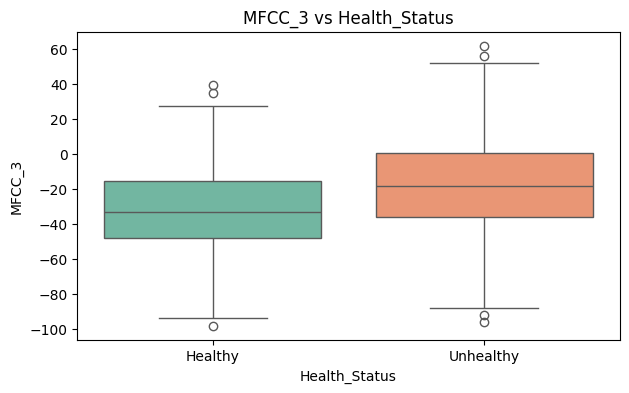

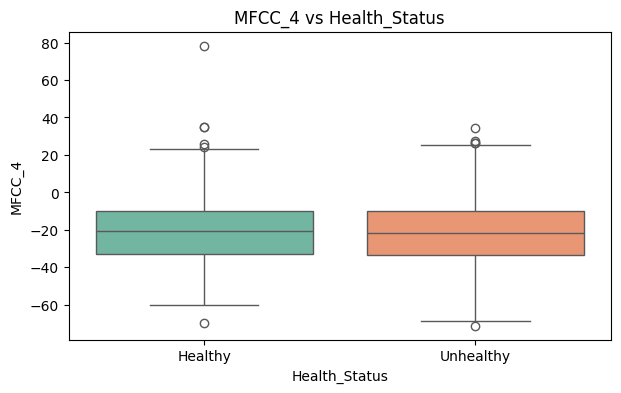

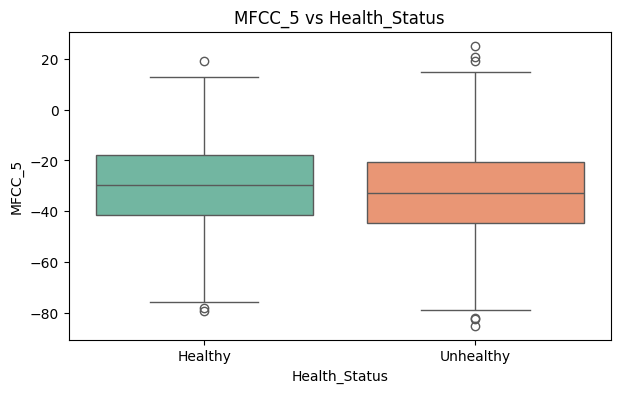

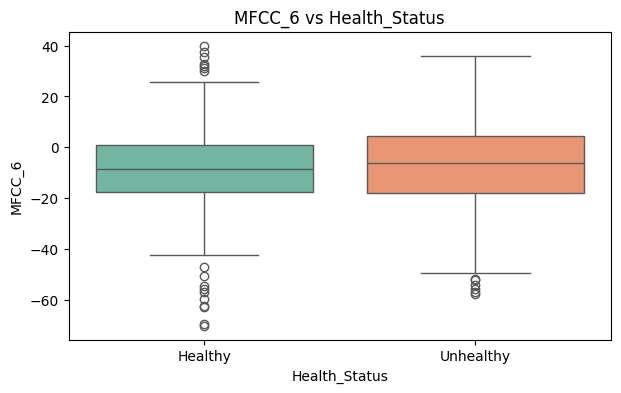

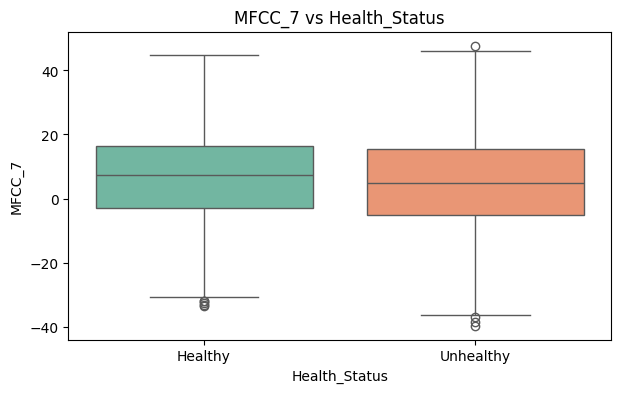

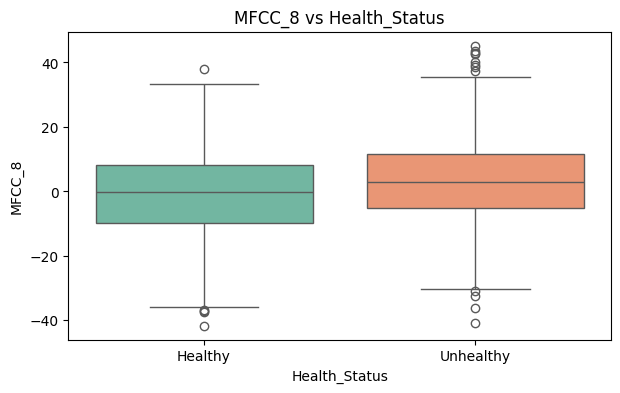

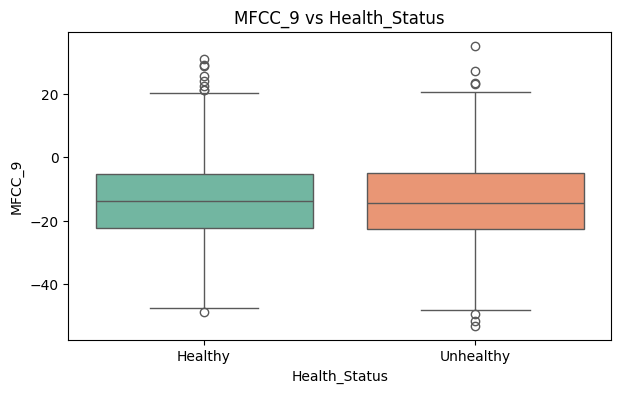

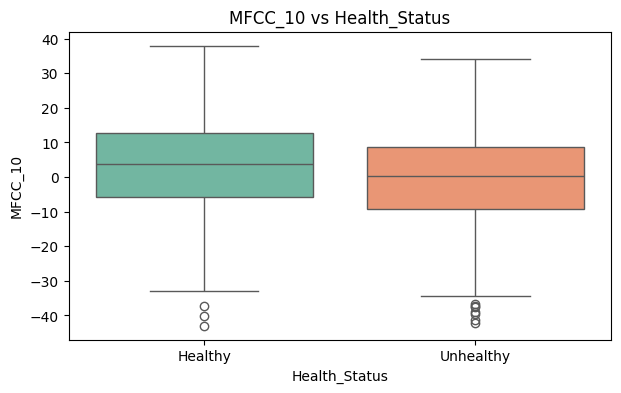

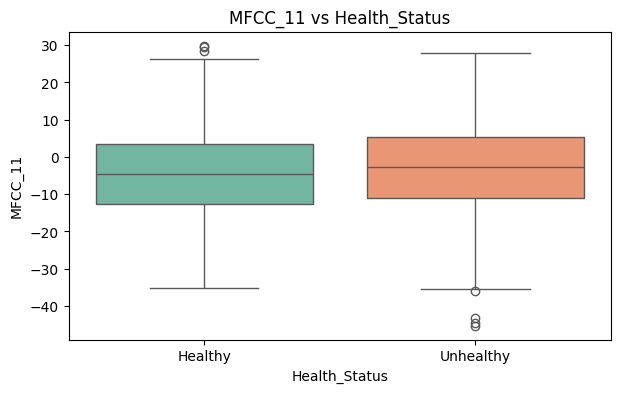

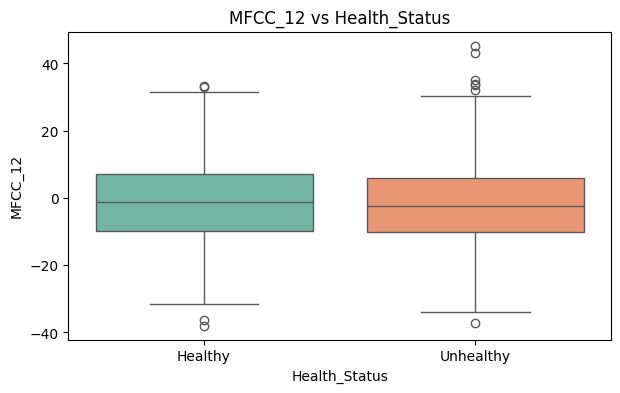

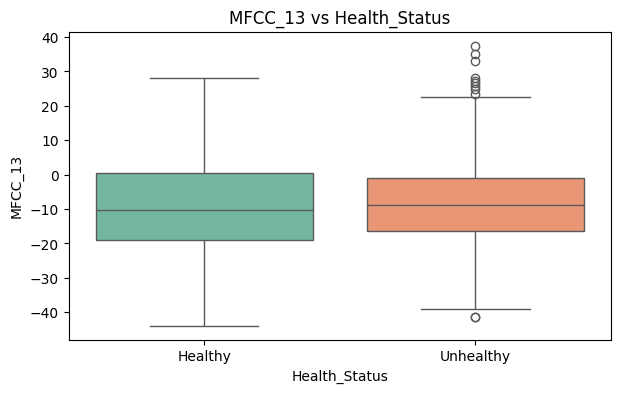

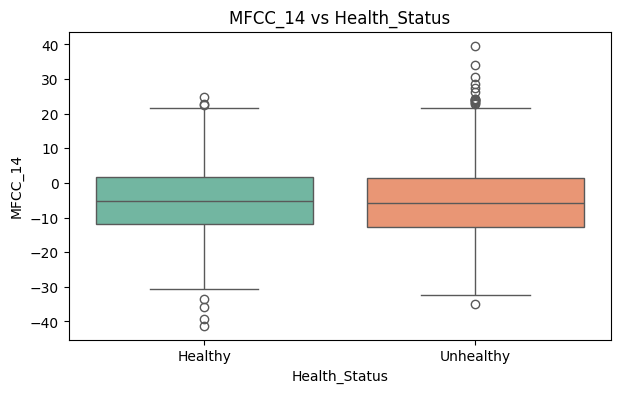

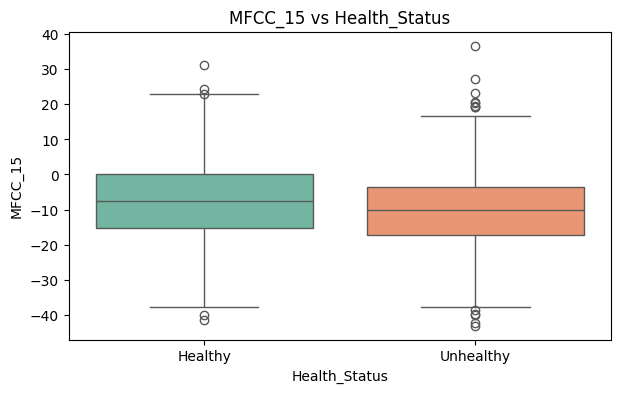

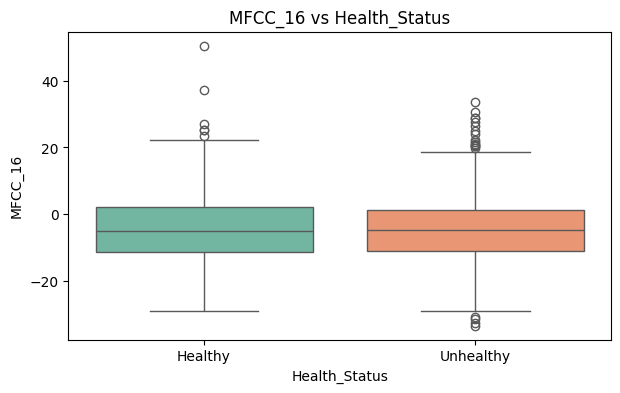

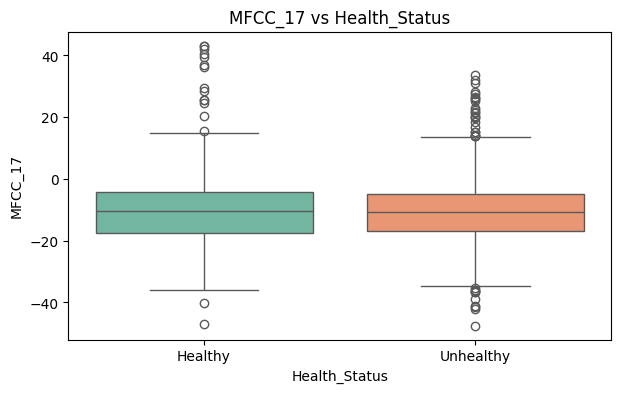

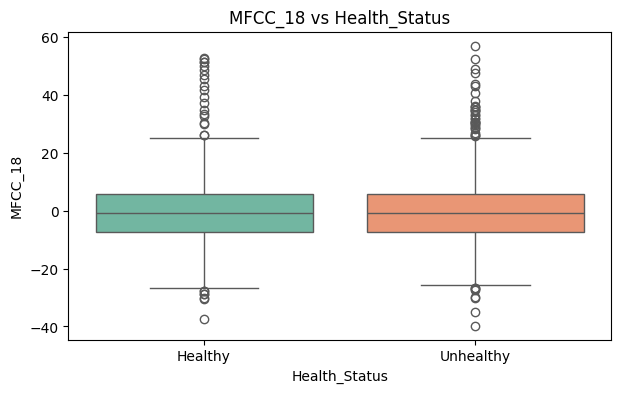

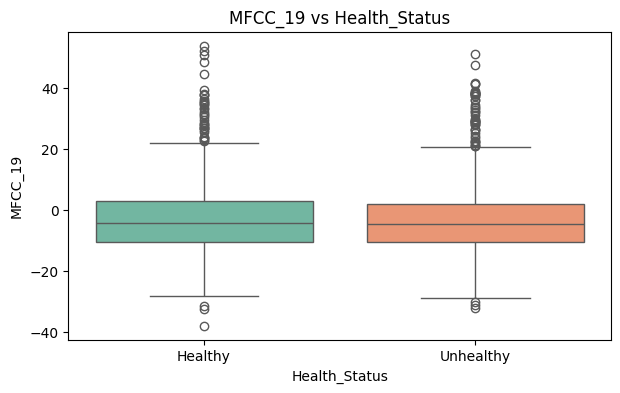

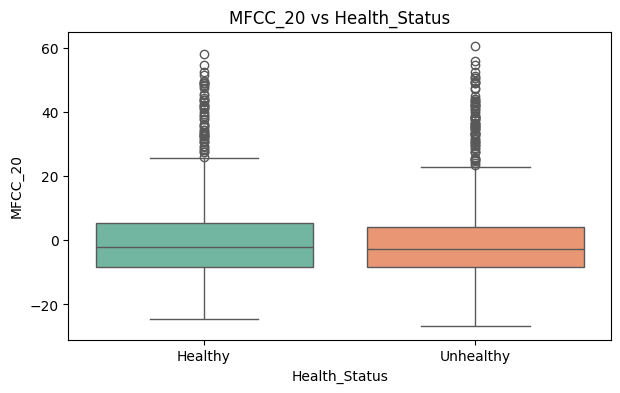

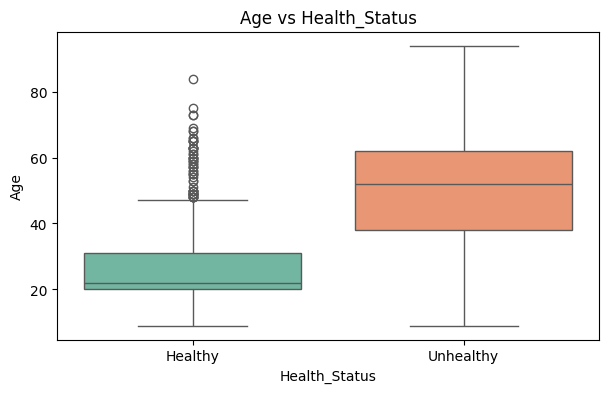

In [22]:
for col in num_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(
        x='Health_Status', y=col, hue='Health_Status',
        data=df_new, palette='Set2', legend=False
    )
    plt.title(f'{col} vs Health_Status')
    plt.xlabel('Health_Status')
    plt.ylabel(col)
    plt.show()

## Bivariate Analysis Summary: Numerical Features vs Health Status

# 1. Signal and Spectral Features

Signal_Energy is higher for healthy individuals, indicating stronger and more stable signal patterns.

Energy_Distribution, Spectral_Brightness, Spectral_Spread, and Spectral_Rolloff are wider and higher for unhealthy individuals, suggesting greater variability and intensity in their spectral properties.

Zero_Crossing_Rate for unhealthy individuals shows many outliers, reflecting irregular signal fluctuations or instability.
# 2. Mel-Frequency Cepstral Coefficients (MFCCs)

The majority of MFCCs show similar distributions between healthy and unhealthy individuals.

MFCC_1, MFCC_3, and MFCC_8 are slightly higher for unhealthy individuals.

MFCC_8 and MFCC_15 are slightly lower for unhealthy individuals.

These subtle variations suggest minor spectral differences between the two health categories.

# 3. Age

Unhealthy individuals tend to be older than healthy ones.

This trend aligns with real-world observations where age often correlates with deteriorating health conditions.

## Correlation Matrix and Heatmap

=== Correlation Matrix ===


,Energy_Distribution,Signal_Energy,Spectral_Brightness,Spectral_Spread,Spectral_Rolloff,Zero_Crossing_Rate,MFCC_1,MFCC_2,MFCC_3,MFCC_4,...,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,Age
Energy_Distribution,1.000000,-0.260006,0.138600,0.065047,0.151392,0.220299,0.428067,0.341504,0.159636,0.110324,...,0.199928,0.150847,0.077281,-0.051134,0.107579,-0.116318,-0.061675,-0.065906,-0.194919,0.218019
Signal_Energy,-0.260006,1.000000,-0.242246,-0.282045,-0.269563,0.010102,0.263653,-0.031392,-0.159616,0.014879,...,0.049695,-0.011777,-0.029826,-0.025470,-0.078564,0.023877,-0.018247,0.045352,0.046663,-0.213185
Spectral_Brightness,0.138600,-0.242246,1.000000,0.872018,0.941539,0.588434,0.512097,-0.687083,-0.027310,-0.327692,...,-0.056718,-0.243109,0.100701,0.080178,0.065515,0.127244,0.179394,0.034657,0.155805,0.129151
Spectral_Spread,0.065047,-0.282045,0.872018,1.000000,0.854334,0.259274,0.420233,-0.621719,0.321418,-0.324030,...,-0.037598,-0.217482,0.108097,0.027836,0.052470,0.068339,0.123504,-0.035707,0.102207,0.189700
Spectral_Rolloff,0.151392,-0.269563,0.941539,0.854334,1.000000,0.438739,0.502890,-0.568680,0.081611,-0.176769,...,-0.012053,-0.163243,0.099787,0.040139,0.075732,0.084854,0.114009,0.022926,0.093363,0.176242
Zero_Crossing_Rate,0.220299,0.010102,0.588434,0.259274,0.438739,1.000000,0.296408,-0.443195,-0.364812,-0.323452,...,-0.034171,-0.151070,0.069919,0.109169,0.022407,0.159919,0.188489,0.104009,0.198824,-0.045347
MFCC_1,0.428067,0.263653,0.512097,0.420233,0.502890,0.296408,1.000000,-0.067424,-0.012270,-0.018006,...,0.150134,-0.043059,0.081569,-0.013546,0.067601,-0.050002,0.001553,-0.073429,-0.122878,0.127160
MFCC_2,0.341504,-0.031392,-0.687083,-0.621719,-0.568680,-0.443195,-0.067424,1.000000,0.228464,0.303401,...,0.221608,0.381860,-0.064443,-0.135680,0.058199,-0.219038,-0.249502,-0.069429,-0.333000,0.110926
MFCC_3,0.159636,-0.159616,-0.027310,0.321418,0.081611,-0.364812,-0.012270,0.228464,1.000000,0.113461,...,0.197093,0.277373,0.091872,-0.153877,0.031505,-0.148102,-0.137833,-0.089790,-0.186995,0.346334
MFCC_4,0.110324,0.014879,-0.327692,-0.324030,-0.176769,-0.323452,-0.018006,0.303401,0.113461,1.000000,...,0.155576,0.308848,0.135560,-0.103218,-0.014637,-0.204292,-0.189685,-0.076881,-0.209738,0.037950


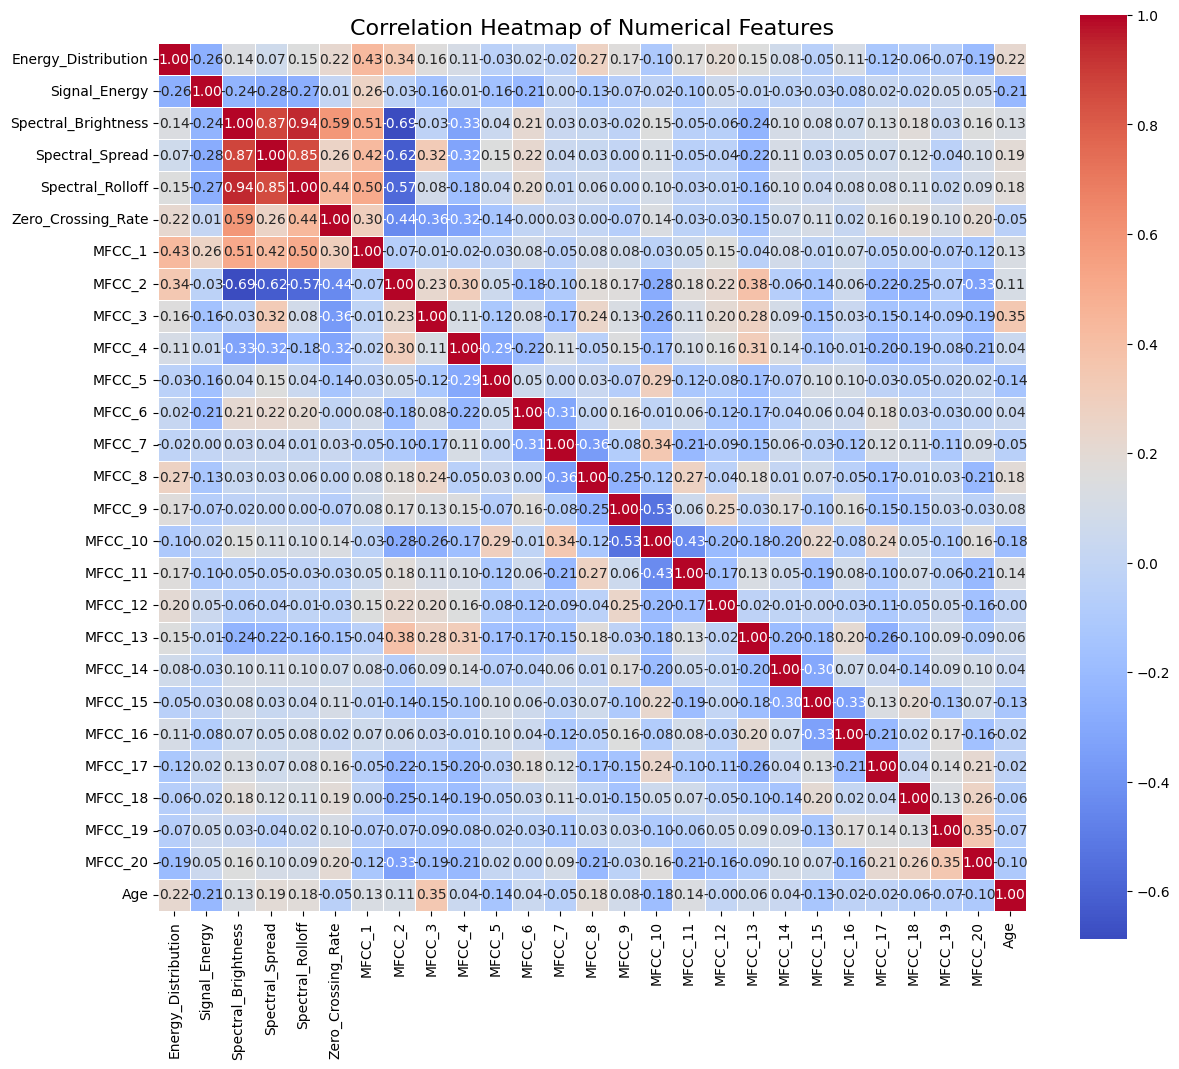

In [23]:
# ------------- 1️⃣ Correlation Matrix -------------
corr_matrix = df_new[num_cols].corr()

# Display the correlation matrix (optional)
print("=== Correlation Matrix ===")
display(corr_matrix)

# ------------- 2️⃣ Heatmap of Correlations -------------
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,         # show correlation values
    fmt=".2f",          # 2 decimal points
    cmap='coolwarm',    # color scheme
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

# Takeaways from Correlation Matrix and Heatmap
There is multicollinearity among spectral features (Spectral_Brightness, Spectral_Spread, Spectral_Rolloff). Spectral_Brightness ↔ Spectral_Rolloff (r = 0.94), Spectral_Brightness ↔ Spectral_Spread (r = 0.87), Spectral_Spread ↔ Spectral_Rolloff (r = 0.85).

MFCC_2 is inversely related to spectral measures, making it potentially valuable as a contrasting feature.

Signal_Energy and Age show low correlations with most variables, indicating independent and potentially informative predictors.

In [24]:
df_new.columns

Index(['Energy_Distribution', 'Signal_Energy', 'Spectral_Brightness',
       'Spectral_Spread', 'Spectral_Rolloff', 'Zero_Crossing_Rate', 'MFCC_1',
       'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
       'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'MFCC_14',
       'MFCC_15', 'MFCC_16', 'MFCC_17', 'MFCC_18', 'MFCC_19', 'MFCC_20',
       'Health_Status', 'Gender', 'Age', 'Age_Bin'],
      dtype='object')

In [25]:
df_new.head()

,Energy_Distribution,Signal_Energy,Spectral_Brightness,Spectral_Spread,Spectral_Rolloff,Zero_Crossing_Rate,MFCC_1,MFCC_2,MFCC_3,MFCC_4,...,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,MFCC_20,Health_Status,Gender,Age,Age_Bin
0,0.127341,0.355538,1587.507015,2002.198851,2737.971816,0.066798,-233.566208,48.504421,-34.518085,-36.272301,...,-28.190628,1.143172,4.134034,52.794827,39.092403,49.037060,Healthy,Female,20,Below-20
1,0.215317,0.250342,1272.900724,1850.302841,1692.919922,0.043325,-179.419601,119.705742,0.882231,-25.167576,...,7.790230,-7.037875,-9.193601,11.183559,-2.173607,-9.420938,Healthy,Female,22,21-40
2,0.212512,0.251419,919.203795,1014.718104,1275.967478,0.047079,-209.186188,167.135651,-37.398190,-12.435701,...,-20.040691,-4.153456,-2.725145,-10.669723,-2.336876,7.741264,Healthy,Male,66,Above-61
3,0.198861,0.157396,1119.517351,1529.490600,1501.657586,0.045487,-210.244278,139.819519,-7.774013,13.630911,...,-0.163550,7.797343,-26.314997,-6.622046,0.535120,0.749695,Healthy,Male,31,21-40
4,0.370113,0.143538,1060.678054,1346.299507,1524.942294,0.050109,-175.039948,181.905212,-33.181606,-0.091763,...,-20.939833,13.306650,-26.597456,-8.324528,10.786009,-6.677513,Healthy,Male,25,21-40


# **Predictive Models**

In [26]:
# Import Libraries
# ==========================================================
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:

# Copy to avoid modifying original
df_model = df_new.copy()

In [28]:
# Encode categorical features - Gender (Female = 0, Male = 1)
le_gender = LabelEncoder()
df_model['Gender'] = le_gender.fit_transform(df_model['Gender'])

# Encode target variable (Healthy = 0, Unhealthy = 1)
le_health = LabelEncoder()
df_model['Health_Status'] = le_health.fit_transform(df_model['Health_Status'])

# Select features and target
X = df_model.drop(['Health_Status', 'Age_Bin'], axis=1)
y = df_model['Health_Status']

In [29]:
X.columns

Index(['Energy_Distribution', 'Signal_Energy', 'Spectral_Brightness',
       'Spectral_Spread', 'Spectral_Rolloff', 'Zero_Crossing_Rate', 'MFCC_1',
       'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
       'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'MFCC_14',
       'MFCC_15', 'MFCC_16', 'MFCC_17', 'MFCC_18', 'MFCC_19', 'MFCC_20',
       'Gender', 'Age'],
      dtype='object')

In [30]:
X.Gender.head()

,Gender
0,0
1,0
2,1
3,1
4,1


In [31]:
y.head()

,Health_Status
0,0
1,0
2,0
3,0
4,0


In [33]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
print( "Length of dataset: " , len(X))
print( "Length of train dataset: " , len(X_train))
print( "Length of test dataset: " , len(X_test))

Length of dataset:  2035
Length of train dataset:  1628
Length of test dataset:  407


In [35]:
# Standardize numerical features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## Decision Tree Classifier – Training, Evaluation & Visualization

=== Decision Tree Performance ===
Accuracy : 0.769
Precision: 0.824
Recall   : 0.830
F1-Score : 0.827

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       137
           1       0.82      0.83      0.83       270

    accuracy                           0.77       407
   macro avg       0.74      0.74      0.74       407
weighted avg       0.77      0.77      0.77       407



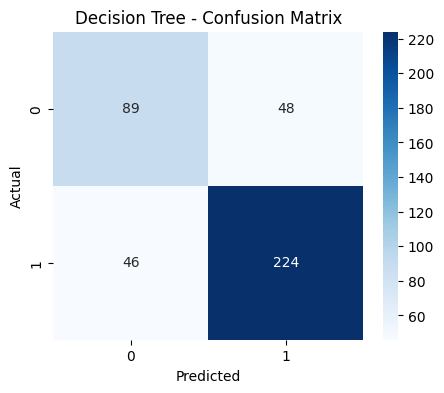

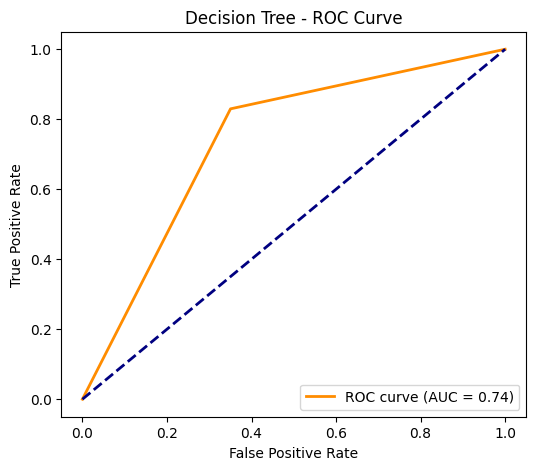

In [36]:
#  Train the Model
# ==========================================================
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_sc, y_train)

# Predict
y_pred = dt_model.predict(X_test_sc)
y_proba = dt_model.predict_proba(X_test_sc)[:, 1]

# ==========================================================
#  Evaluate Model Performance
# ==========================================================
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== Decision Tree Performance ===")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-Score : {f1:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ==========================================================
#  Confusion Matrix
# ==========================================================
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================================================
#  ROC Curve
# ==========================================================
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree - ROC Curve')
plt.legend(loc="lower right")
plt.show()


## Random Forest Classifier – Training, Evaluation & Visualization

=== Random Forest Performance ===
Accuracy: 0.8452
Precision: 0.8657
Recall: 0.9074
F1 Score: 0.8861


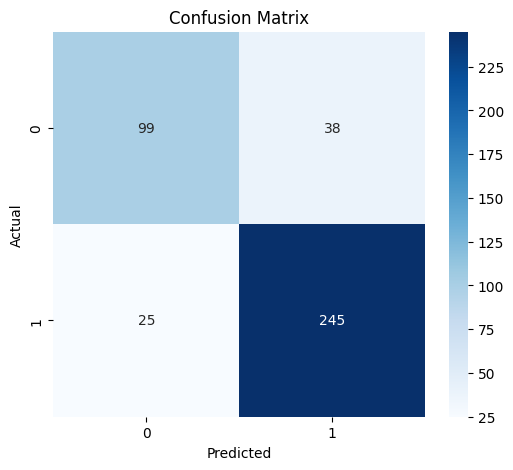

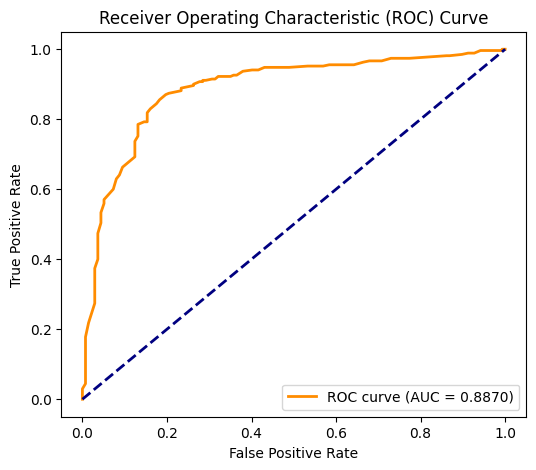

In [39]:

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_sc, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_sc)
y_prob = rf_model.predict_proba(X_test_sc)[:, 1]  # For ROC curve

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== Random Forest Performance ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## XGBoost Classifier – Training, Evaluation & Visualization

=== XGBoost Model Performance ===
Accuracy: 0.8428
Precision: 0.8705
Recall: 0.8963
F1 Score: 0.8832


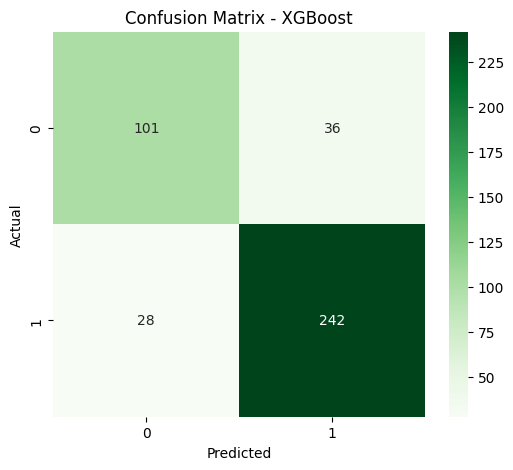

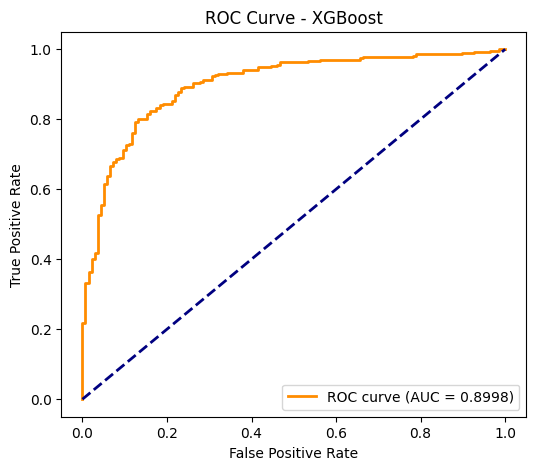

In [38]:


# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_sc, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_sc)
y_prob = xgb_model.predict_proba(X_test_sc)[:, 1]  # probability for ROC curve

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== XGBoost Model Performance ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()




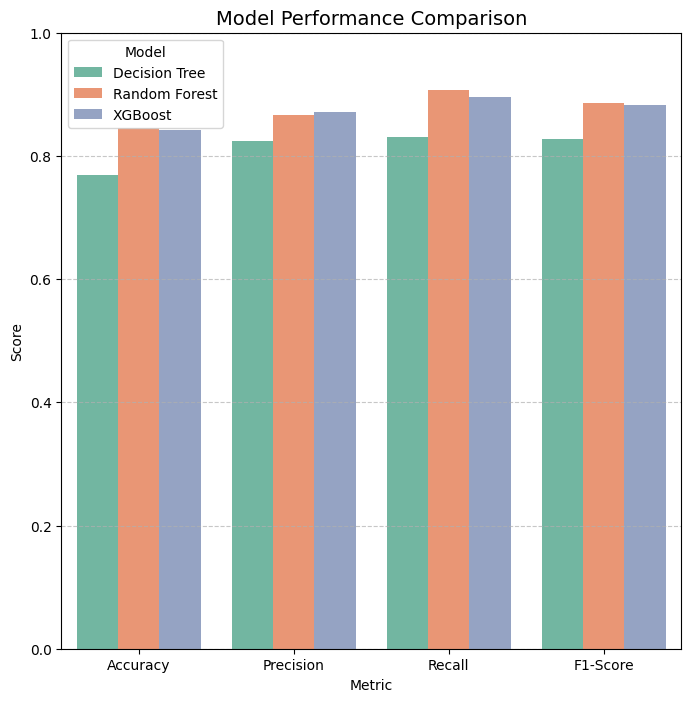

In [ ]:
data = {
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.769, 0.8452, 0.8428],
    'Precision': [0.824, 0.8657, 0.8705],
    'Recall': [0.830, 0.9074, 0.8963],
    'F1-Score': [0.827, 0.8861, 0.8832]
}

df1 = pd.DataFrame(data)

# Transform data for Seaborn
df1_melt = df1.melt(id_vars='Model', var_name='Metric', value_name='Score')

# 3. Plot
plt.figure(figsize=(8,8))
sns.barplot(x='Metric', y='Score', hue='Model', data=df1_melt, palette='Set2')

plt.title('Model Performance Comparison', fontsize=14)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Key insights and summary of the perfomance of these models


| Model         | Accuracy | Precision | Recall | F1-Score | Insights                                                                          |
| ------------- | -------- | --------- | ------ | -------- | --------------------------------------------------------------------------------- |
| Decision Tree | 0.769    | 0.824     | 0.830  | 0.827    | Lowest overall performance; higher misclassifications; simple and fast.           |
| Random Forest | 0.8452   | 0.8657    | 0.9074 | 0.8861   | Best overall performance; high accuracy and recall; robust and reliable.          |
| XGBoost       | 0.8428   | 0.8705    | 0.8963 | 0.8832   | Competitive with Random Forest; slightly higher precision, slightly lower recall. |


Key Takeaways:

Ensemble methods (Random Forest, XGBoost) outperform a single Decision Tree.

Random Forest shows the best balance across all metrics.

XGBoost is very close to Random Forest and could be further optimized for specific priorities (e.g., maximizing precision).

# Preparing the data for Power BI

In [ ]:
df.shape

(2035, 29)

In [ ]:
df.columns

Index(['Energy_Distribution', 'Signal_Energy', 'Spectral_Brightness',
       'Spectral_Spread', 'Spectral_Rolloff', 'Zero_Crossing_Rate', 'MFCC_1',
       'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
       'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'MFCC_14',
       'MFCC_15', 'MFCC_16', 'MFCC_17', 'MFCC_18', 'MFCC_19', 'MFCC_20',
       'Health_Status', 'Gender', 'Age'],
      dtype='object')

In [ ]:
df_original = pd.read_csv("/content/VowelA_High_latest.csv")
print("Loaded dataset with shape:", df_original.shape)

Loaded dataset with shape: (2035, 32)


In [ ]:
df_PBI = df_new.copy()

In [ ]:
df_PBI['ID'] = df_original['ID']

In [ ]:
df_PBI.columns

Index(['Energy_Distribution', 'Signal_Energy', 'Spectral_Brightness',
       'Spectral_Spread', 'Spectral_Rolloff', 'Zero_Crossing_Rate', 'MFCC_1',
       'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8',
       'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'MFCC_14',
       'MFCC_15', 'MFCC_16', 'MFCC_17', 'MFCC_18', 'MFCC_19', 'MFCC_20',
       'Health_Status', 'Gender', 'Age', 'Age_Bin', 'ID'],
      dtype='object')

In [ ]:
# Export DataFrame to CSV
df_PBI.to_csv('VowelA_PBI.csv', index=False)

In [ ]:
df_PBI.dtypes

,0
Energy_Distribution,float64
Signal_Energy,float64
Spectral_Brightness,float64
Spectral_Spread,float64
Spectral_Rolloff,float64
Zero_Crossing_Rate,float64
MFCC_1,float64
MFCC_2,float64
MFCC_3,float64
MFCC_4,float64
